A notebook to explore and plot the timing of different warming levels projected in CMIP6 models globally or within California

# Setup

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import gcsfs
import pandas as pd
import cftime
import datetime
import regionmask


In [3]:
plt.style.use('ggplot')


font = {
            'weight' : 'normal',
            'size'   : 12}
rc('font', **font)


states = regionmask.defined_regions.natural_earth.us_states_50

import warnings
warnings.filterwarnings('ignore')


/home/willkrantz/miniconda3/envs/pangeo_spei/lib/python3.10/site-packages/regionmask/defined_regions/_natural_earth.py:471: FutureWarning: ``regionmask.defined_regions.natural_earth`` is deprecated. Please use ``regionmask.defined_regions.natural_earth_v4_1_0`` or ``regionmask.defined_regions.natural_earth_v5_0_0`` instead.
  warnings.warn(


In [4]:
# get CMIP6 data from google servers
frequency = 'Amon'
var = 'tas'
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
all_models = list(set(df[(df.experiment_id == 'historical')& 
       (df.table_id == frequency)&
       (df.variable_id == var)].source_id))
gcs = gcsfs.GCSFileSystem(token='anon')

# General Functions

In [5]:
def weighted_mean(da):
    ''' simple area weighted mean for regional data'''
    
    # make 2d array of weights in case that lat is 1d
    if len(da.lat.shape)==2:
        weights=np.cos(np.deg2rad(da.lat))
    elif len(da.lat.shape)==1:
        weights = xr.ones_like(da)* (np.cos(np.deg2rad((da.lat))).values)[:,np.newaxis]
        
    # turn weights into nan where da is nan
    weights = weights*da/da
    
    
    if 'lat' in da.dims:
        wm = (da*weights).sum(dim=['lat','lon']) / weights.sum(dim=['lat','lon'])

    elif 'i' in da.dims:
        wm = (da*weights).sum(dim=['i','j']) / weights.sum(dim=['i','j'])
    elif 'nlat' in da.dims:
        wm = (da*weights).sum(dim=['nlat','nlon']) / weights.sum(dim=['nlat','nlon'])
    elif 'x' in da.dims:
        wm = (da*weights).sum(dim=['x','y']) / weights.sum(dim=['x','y'])
    return wm

In [7]:
# following methods from https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
# for more accurate area-weighted spatial mean over global data

def area_grid(lat, lon):
    """
    Calculate the area of each grid cell
    Area is in square meters
    
    Input
    -----------
    lat: vector of latitude in degrees
    lon: vector of longitude in degrees
    
    Output
    -----------
    area: grid-cell area in square-meters with dimensions, [lat,lon]
    
    Notes
    -----------
    Based on the function in
    https://github.com/chadagreene/CDT/blob/master/cdt/cdtarea.m
    """
    from numpy import meshgrid, deg2rad, gradient, cos
    from xarray import DataArray

    xlon, ylat = meshgrid(lon, lat)
    R = earth_radius(ylat)

    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))

    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))

    area = dy * dx

    xda = DataArray(
        area,
        dims=["lat", "lon"],
        coords={"lat": lat, "lon": lon},
        attrs={
            "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
        },
    )
    return xda


def earth_radius(lat):
    '''
    calculate radius of Earth assuming oblate spheroid
    defined by WGS84
    
    Input
    ---------
    lat: vector or latitudes in degrees  
    
    Output
    ----------
    r: vector of radius in meters
    
    Notes
    -----------
    WGS84: https://earth-info.nga.mil/GandG/publications/tr8350.2/tr8350.2-a/Chapter%203.pdf
    '''
    from numpy import deg2rad, sin, cos

    # define oblate spheroid from WGS84
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )

    # radius equation
    # see equation 3-107 in WGS84
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )

    return r

def thorough_weighted_average(da):
    da_area = area_grid(da['lat'],da['lon'])
    total_area = da_area.sum(['lat','lon'])
    temp_weighted=(da*da_area)/total_area
    da_weighted_mean = temp_weighted.sum(['lat','lon'])
    return da_weighted_mean


In [8]:
def standardize_coords(dat):
    try:
        dat=dat.rename({"longitude":"lon", "latitude":"lat"}) #problematic coord names
    except: pass
    dat = xr.decode_cf(dat, use_cftime = True)
    return dat 

In [9]:
def get_gcm_gcloud_data(source_id,var,table_id,scenario,member,activity_id):
    df_hist = df[(df.source_id == source_id) & (df.variable_id == var) & 
                     (df.table_id == table_id) & (df.experiment_id == scenario) &
                     (df.member_id == member) & (df.activity_id == activity_id)]

    if len(df_hist)>0:
        dat = xr.open_zarr(gcs.get_mapper(df_hist.zstore.values[-1]))
        dat = standardize_coords(dat)
    else:
        return None
        
    return dat

# 1. Get warming anomaly for each GCM

In [10]:
def get_gcm_warming(gcm,member,ssp,region='global',climo_length=30, center_label=True,
                    ref_start_year = '1850', ref_end_year = '1900'):
    
    fut_temp = get_gcm_gcloud_data(gcm,'tas','Amon',ssp,member,'ScenarioMIP')
    hist_temp = get_gcm_gcloud_data(gcm,'tas','Amon','historical',member,'CMIP')

    hist_temp = hist_temp.tas.resample(time='1AS').mean()
    fut_temp = fut_temp.tas.resample(time='1AS').mean()
    

    if region == 'CA':
        if hist_temp.lon.max().values < 350:
                wrap = False
        else:
                wrap= True
                
        mask = states.mask(hist_temp.lon, hist_temp.lat, wrap_lon=wrap)
        
        hist_temp=hist_temp.where(mask==4,drop=True)
        fut_temp=fut_temp.where(mask==4,drop=True)
        
        #the other weighted mean doesn't work on small cropped data
        hist_temp_mean = weighted_mean(hist_temp)
        fut_temp_mean = weighted_mean(fut_temp)
    
    else:
        #if not california, default to global
        hist_temp_mean=thorough_weighted_average(hist_temp)
        fut_temp_mean=thorough_weighted_average(fut_temp)

    comb_temp_mean = xr.concat([hist_temp_mean,fut_temp_mean],dim='time')
    
    pi_temp = hist_temp_mean.sel(time=slice(ref_start_year, ref_end_year)).mean().values
    
    # default is center labeling the climatologies. If set to False, they will be right-edge labeled
    climo_warming = comb_temp_mean.rolling(time=climo_length,center=center_label).mean()
    warming = climo_warming-pi_temp
    warming.load()
    return warming

In [17]:
# demonstrate on CESM2
gcm_warming=get_gcm_warming('CESM2','r11i1p1f1','ssp370')
gcm_warming_585=get_gcm_warming('CESM2','r11i1p1f1','ssp585')

Text(0, 0.5, 'Mean Temperature Anomaly (C)')

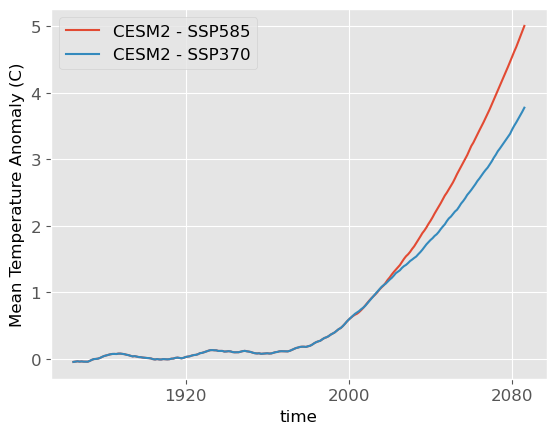

In [18]:

gcm_warming_585.plot(label='CESM2 - SSP585')
gcm_warming.plot(label='CESM2 - SSP370')
plt.legend()
plt.ylabel('Mean Temperature Anomaly (C)')

# 2. Find warming level crossings

In [19]:
def get_intercepts(warming_climo,intercepts,plot=True):
    # will find the first time warming crosses this level
    # involves a lot of futzing with model date formatting to make consistent plots

    cross_years = []
    for intercept in intercepts:
        cross_dates = warming_climo.where(warming_climo>intercept,drop=True).time.values
        
        if len(cross_dates)>0:
            
            if type(cross_dates[0])==np.datetime64:
                cross_year= cross_dates[0].astype('datetime64[Y]').astype(int) + 1970
                
                years=[y.astype('datetime64[Y]').astype(int) + 1970 for y in warming_climo.time.values]
                
            elif ((type(cross_dates[0])==cftime._cftime.DatetimeNoLeap) or
                  (type(cross_dates[0])==cftime._cftime.Datetime360Day)):
                cross_year = cross_dates[0].year
                years = [y.year for y in warming_climo.time.values]
                
            else:
                raise Exception("Don't understand this date type")
                
        else:
            cross_year = np.nan
        cross_years.append(cross_year)
    
    if plot==True:
        colors=['#ead4ba','#fdae6b','#e6550d']
        
        plt.figure()
        ax = plt.gca()
        for i,t in enumerate(intercepts):
            ax.axhline(t,c=colors[i%3])
            ax.axvline(cross_years[i],c=colors[i%3])
        plt.plot(years,warming_climo.values,'k')
        plt.xlabel('year')
        plt.ylabel('Mean Temperature Anomaly (C)')

        plt.show()
        
    return cross_years

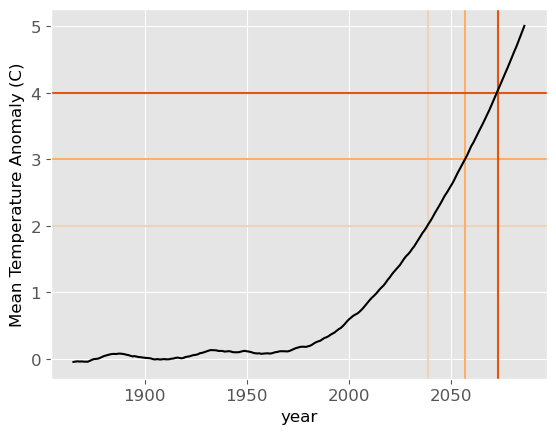

In [20]:
cross_years = get_intercepts(gcm_warming_585,[2,3,4])

## Combine into one function

In [11]:
def get_warming_levels(gcm,member,ssp,region='global',climo_length=30,warming_levels=[2,3,4],plot=True):
    gcm_warming=get_gcm_warming(gcm,member,ssp,region,climo_length=climo_length)
    cross_years = get_intercepts(gcm_warming,warming_levels,plot=plot)
    return cross_years

## Example: different definitions for the averaging period can give very different crossing years

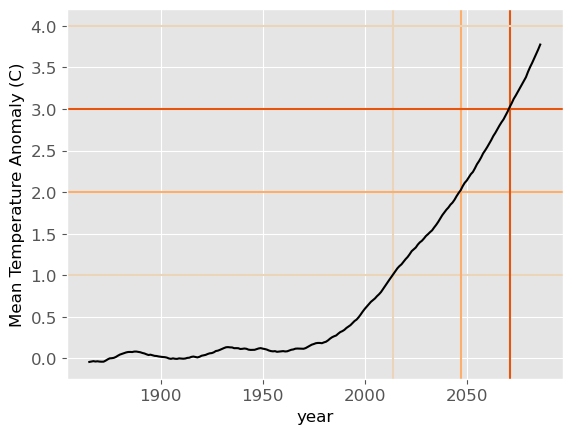

[2014, 2047, 2071, nan]

In [22]:
# default is 30
get_warming_levels('CESM2','r11i1p1f1','ssp370',warming_levels=[1,2,3,4])

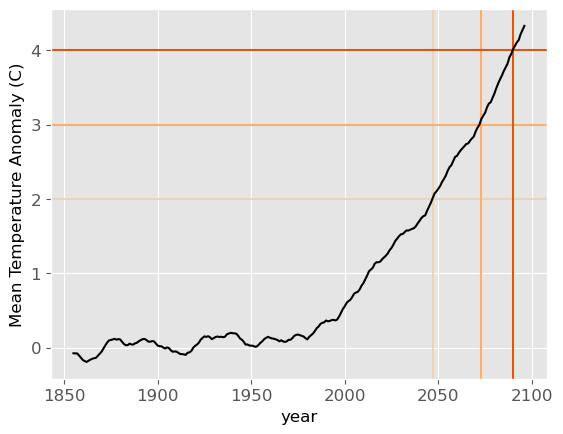

[2047, 2073, 2090]

In [23]:
get_warming_levels('CESM2','r11i1p1f1','ssp370',climo_length=10)


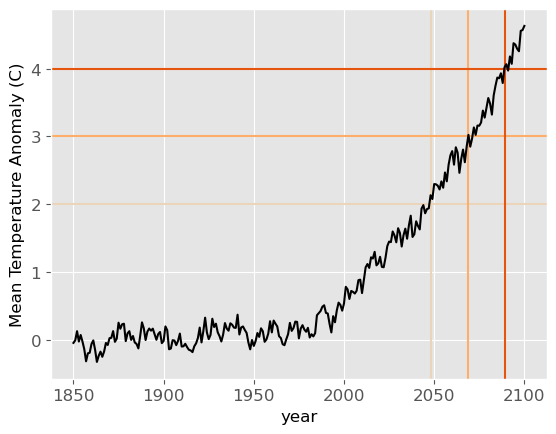

[2048, 2069, 2089]

In [24]:
#climo_length of 1 will find the first year that crosses the temperature threshold

get_warming_levels('CESM2','r11i1p1f1','ssp370',climo_length=1)

## Get the warming level crossing years for a set of model runs

In [12]:
# define the set of models and individual simulations to examine

models_members = {'CESM2':['r11i1p1f1'],
        'CNRM-ESM2-1':['r1i1p1f2'],
         'EC-Earth3-Veg':['r1i1p1f1'],
          'EC-Earth3':['r1i1p1f1'],
         'FGOALS-g3':['r2i1p1f1'],
        'UKESM1-0-LL':['r2i1p1f2'],
        'MPI-ESM1-2-LR':['r7i1p1f1'],
        'ACCESS-CM2':['r5i1p1f1'],
         'CanESM5':['r1i1p2f1']}

CESM2 r11i1p1f1


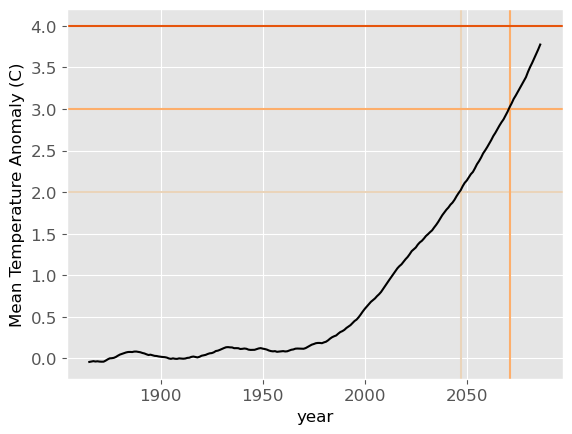

[2047, 2071, nan]
CNRM-ESM2-1 r1i1p1f2


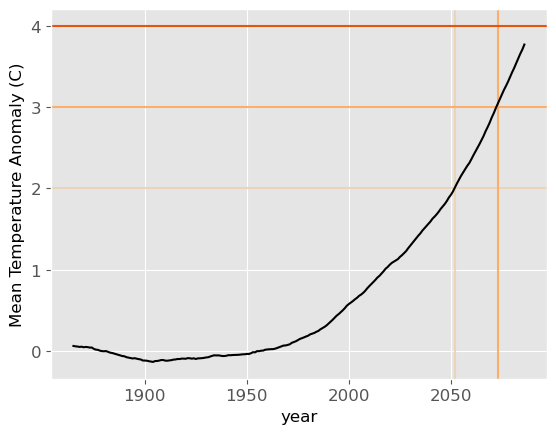

[2052, 2073, nan]
EC-Earth3-Veg r1i1p1f1


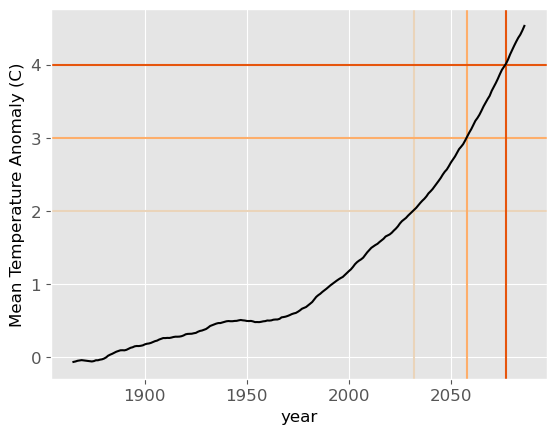

[2032, 2058, 2077]
EC-Earth3 r1i1p1f1


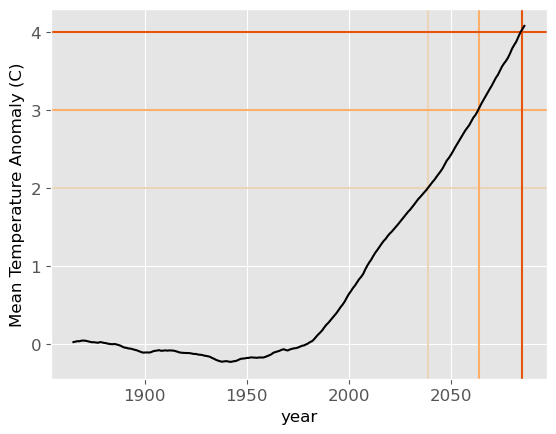

[2039, 2064, 2085]
FGOALS-g3 r2i1p1f1


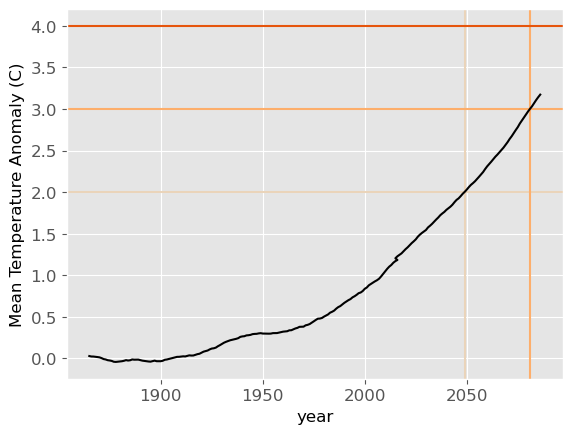

[2049, 2081, nan]
UKESM1-0-LL r2i1p1f2


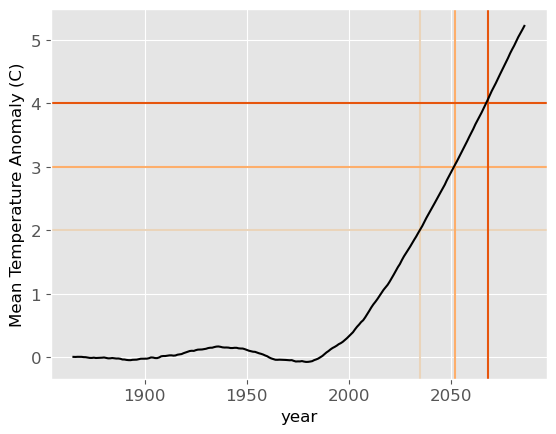

[2035, 2052, 2068]
MPI-ESM1-2-LR r7i1p1f1


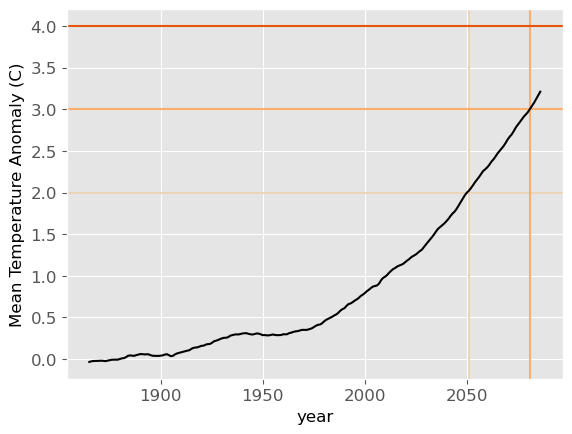

[2051, 2081, nan]
ACCESS-CM2 r5i1p1f1


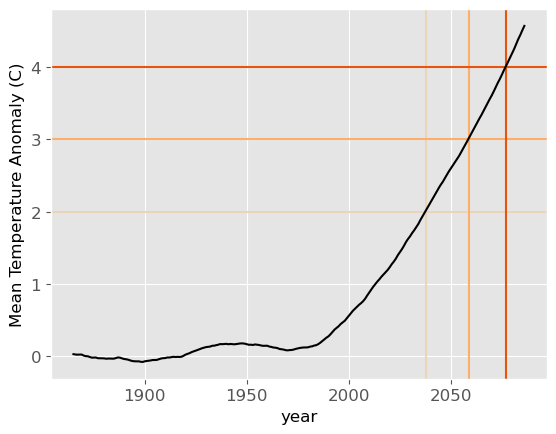

[2038, 2059, 2077]
CanESM5 r1i1p2f1


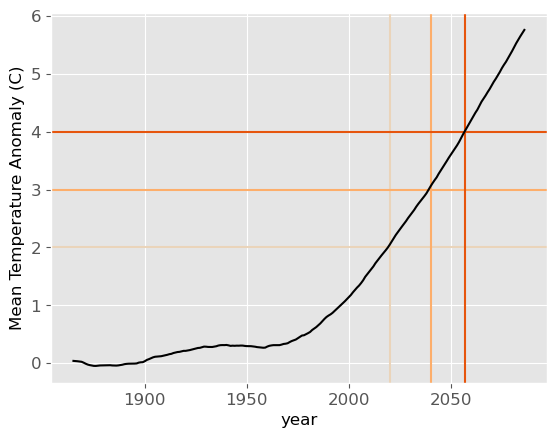

[2020, 2040, 2057]


In [26]:
warming_years = {}
for model in models_members:
    for member in models_members[model]:
        print(model,member)
        years = get_warming_levels(model,member,'ssp370')
        print(years)
        warming_years[model]=years

In [27]:
warming_years

{'CESM2': [2047, 2071, nan],
 'CNRM-ESM2-1': [2052, 2073, nan],
 'EC-Earth3-Veg': [2032, 2058, 2077],
 'EC-Earth3': [2039, 2064, 2085],
 'FGOALS-g3': [2049, 2081, nan],
 'UKESM1-0-LL': [2035, 2052, 2068],
 'MPI-ESM1-2-LR': [2051, 2081, nan],
 'ACCESS-CM2': [2038, 2059, 2077],
 'CanESM5': [2020, 2040, 2057]}

In [13]:
#do it for California-only warming
warming_years = {}
for model in models_members:
    for member in models_members[model]:
        print(model,member)
        years = get_warming_levels(model,member,'ssp370',region='CA')
        print(years)
        warming_years[model]=years

CESM2 r11i1p1f1


NameError: name 'get_intercepts' is not defined

## Plot ensemble of CMIP6 models

In [29]:
def multi_model_plot(gcm_dict):
    climo_length=30
    plt.figure(figsize=(10,8))
    for model in gcm_dict:
        for member in gcm_dict[model]:
            warming_climo=get_gcm_warming(model,member,'ssp370',climo_length=climo_length)
            
            cross_years = get_intercepts(warming_climo,[1,2,3],plot=False)
            
            dates = warming_climo.time.values
            
            if type(dates[0])==np.datetime64:
                years=[y.astype('datetime64[Y]').astype(int) + 1970 for y in dates]
                
            elif ((type(dates[0])==cftime._cftime.DatetimeNoLeap) or
                  (type(dates[0])==cftime._cftime.Datetime360Day)):
                years = [y.year for y in dates]
                
            plt.plot(years,warming_climo.values,label=model+ ' - '+member)
    plt.legend()
    plt.minorticks_on()
    plt.grid(visible=True,which='minor',axis='both',color='#DDDDDD')
    plt.show()
        

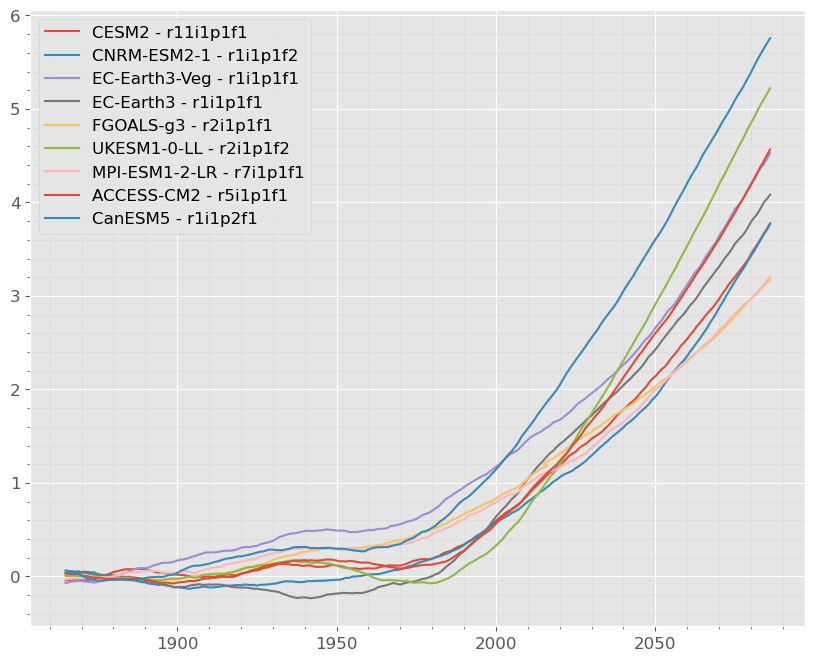

In [30]:
multi_model_plot(models_members)

In [31]:
def multi_model_plot_with_crossings(gcm_dict,climo_length=30):

    all_crossings = []
    plt.figure(figsize=(10,8))
    colors=['#fee6ce','#fdae6b','#e6550d']
    for model in gcm_dict:
        for member in gcm_dict[model]:
            warming_climo=get_gcm_warming(model,member,'ssp370',climo_length=climo_length)
            
            cross_years = get_intercepts(warming_climo,[1,2,3],plot=False)
            all_crossings.append(cross_years)
            
            dates = warming_climo.time.values
            
            if type(dates[0])==np.datetime64:
                
                years=[y.astype('datetime64[Y]').astype(int) + 1970 for y in dates]
                
            elif ((type(dates[0])==cftime._cftime.DatetimeNoLeap) or
                  (type(dates[0])==cftime._cftime.Datetime360Day)):
                years = [y.year for y in dates]
                
            plt.plot(years,warming_climo.values,label=model+ ' - '+member)
    ax = plt.gca()
    for warming_level in [1,2,3]:
        first = np.nanmin([y[warming_level-1] for y in all_crossings])
        last = np.nanmax([y[warming_level-1] for y in all_crossings])
        
        ax.axvspan(first, last, alpha=0.7, color=colors[warming_level-1])
        print(f'{warming_level} degrees of warming between {first} and {last}')
    
    plt.legend()
    plt.minorticks_on()
    plt.grid(visible=True,which='minor',axis='both',color='#DDDDDD')
    plt.show()

1 degrees of warming between 1993 and 2018
2 degrees of warming between 2020 and 2052
3 degrees of warming between 2040 and 2081


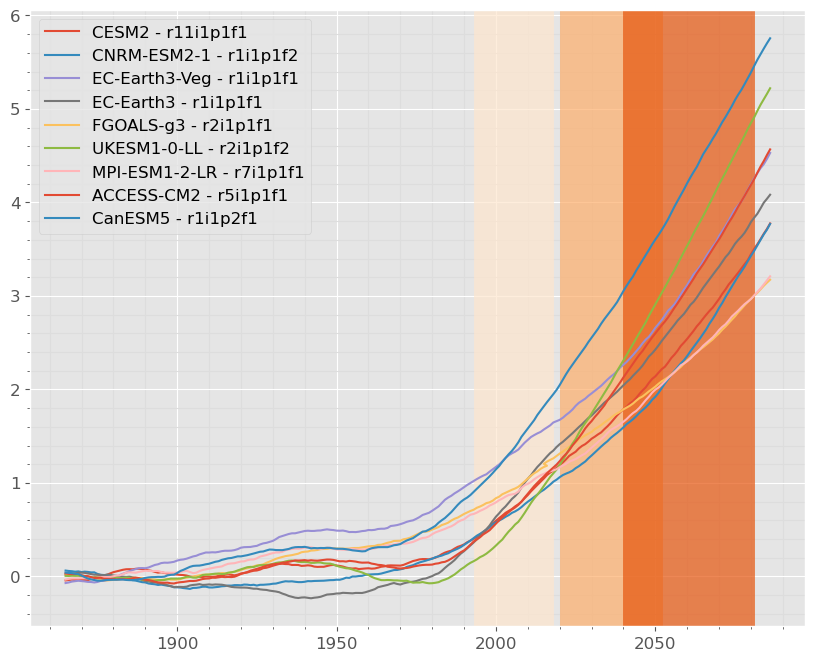

In [32]:
multi_model_plot_with_crossings(models_members)

# 3. Warming levels versus C02 concentrations

## Load historical and future co2 levels that the GCMs use

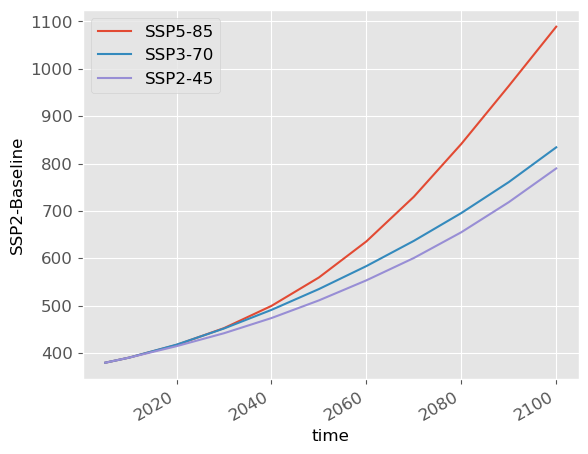

In [121]:
# c02 concentrations from https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage
ssp_co2 = pd.read_excel('iamc_db_concentrations.xlsx')
ssp_co2=ssp_co2.T
headers = ssp_co2.iloc[1]
ssp_co2 = ssp_co2[5:-1]
ssp_co2.columns = headers
ssp_co2=ssp_co2.dropna(axis='columns')


ssp_dts = [datetime.datetime(2005, 1, 1, 0, 0),
           datetime.datetime(2010, 1, 1, 0, 0),
           datetime.datetime(2020, 1, 1, 0, 0),
           datetime.datetime(2030, 1, 1, 0, 0),
           datetime.datetime(2040, 1, 1, 0, 0),
           datetime.datetime(2050, 1, 1, 0, 0),
           datetime.datetime(2060, 1, 1, 0, 0),
           datetime.datetime(2070, 1, 1, 0, 0),
           datetime.datetime(2080, 1, 1, 0, 0),
           datetime.datetime(2090, 1, 1, 0, 0),
           datetime.datetime(2100, 1, 1, 0, 0)]

# convert pandas to xarray and replace the time index with propper dts
ssp_co2_xa = ssp_co2.to_xarray()
ssp_co2_xa = ssp_co2_xa.rename({'index':'time'})
ssp_co2_xa = ssp_co2_xa.assign_coords(time=ssp_dts)

#datatype needs to be converted for some reason
for ssp in ['SSP2-Baseline','SSP3-Baseline','SSP5-Baseline']:
    ssp_co2_xa[ssp]=ssp_co2_xa[ssp].astype('float')
    
ssp_co2_xa['SSP5-Baseline'].plot(label='SSP5-85')
ssp_co2_xa['SSP3-Baseline'].plot(label='SSP3-70')
ssp_co2_xa['SSP2-Baseline'].plot(label='SSP2-45')
plt.legend()

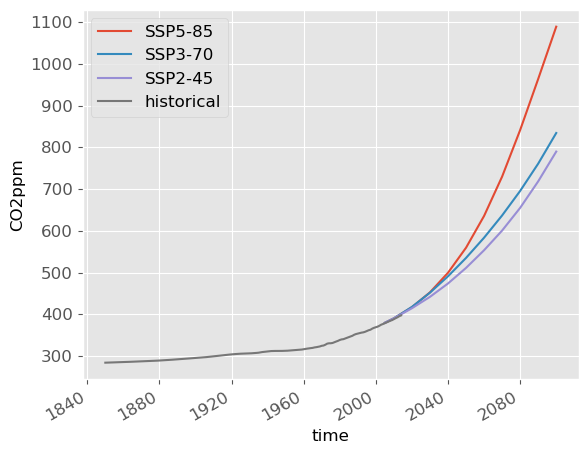

In [122]:
# historical c02 levels from https://gmd.copernicus.org/articles/10/2057/2017/gmd-10-2057-2017.html
hist_co2 = pd.read_excel('cmip_hist_co2.xls.xlsx')
hist_co2 = hist_co2.set_index('year')
hist_co2_xa = hist_co2.to_xarray()
hist_co2_xa['year']=[datetime.datetime(yr,1,1) for yr in hist_co2_xa.year.values]
hist_co2_xa = hist_co2_xa.rename({'year':'time'})
ssp_co2_xa['SSP5-Baseline'].plot(label='SSP5-85')
ssp_co2_xa['SSP3-Baseline'].plot(label='SSP3-70')
ssp_co2_xa['SSP2-Baseline'].plot(label='SSP2-45')
hist_co2_xa.CO2ppm.plot(label='historical')
plt.legend()

In [123]:
ssp_co2_xa['time'] = ssp_co2_xa.time.dt.strftime('%Y').astype(int)

In [124]:
def plot_warming_vs_co2(gcm,member, climo_length=30):
    scenario_dict = {'ssp245':'SSP2-Baseline','ssp370':'SSP3-Baseline','ssp585':'SSP5-Baseline'}

    for scenario in ['ssp245','ssp370','ssp585']:
        warming_climo = get_gcm_warming(gcm,member,scenario,climo_length=climo_length)
        warming_climo['time'] = warming_climo.time.dt.strftime('%Y').astype(int)
        co2 = ssp_co2_xa[scenario_dict[scenario]].interp(time=warming_climo.time).values
        gcm_warming = warming_climo.values
        plt.plot(co2,gcm_warming,label=scenario)
    plt.xlabel('CO2 Concentration (ppm)')
    plt.ylabel('Temperature Anomaly (C)')
    plt.legend()
    plt.show()
    
    


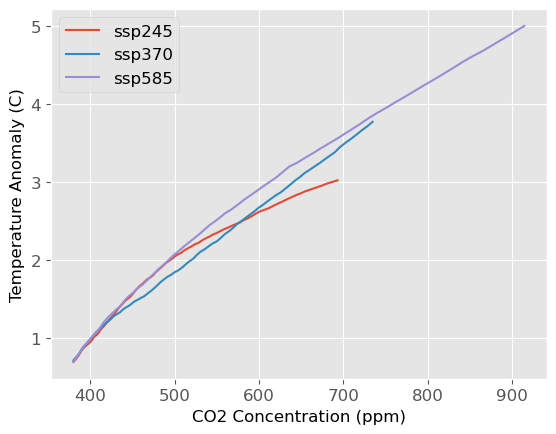

In [125]:
plot_warming_vs_co2('CESM2','r11i1p1f1')

# Misc tools

## Find doublings

In [38]:
everyyear = [datetime.datetime(yr,1,1) for yr in np.arange(2005,2100)]
ssp_co2_interp = ssp_co2_xa['SSP5-Baseline'].interp(time=everyyear)
pi_co2 = hist_co2_xa.CO2ppm.sel(time=slice('1850','1900')).mean().values

def doublings_by_climo(yr,climo_length):
    ratio = ssp_co2_interp.sel(time=slice(str(yr-climo_length),str(yr))).mean()/pi_co2
    doublings = np.log(ratio)/np.log(2)
    return float(doublings.values)

In [39]:
#check
doublings_by_climo(2053,1)

1.0018530820534648

In [40]:
# over the 30-year climatology leading up to 2053, the average co2 level had doubled this many times
doublings_by_climo(2053,30)

0.7778325172082965

In [41]:
doublings_by_climo(2100,30)

1.6372751998466415

# Temperature increase by a certain time period

In [132]:
target_year = '2000'
climo_length = 30
ssp = 'ssp370'
warming_years = {}
all_warmings = []

print(f'Degrees of warming by {target_year}')
for model in models_members:
    for member in models_members[model]:
        gcm_warming=get_gcm_warming(model,member,ssp,climo_length=climo_length)
        all_warmings.append(gcm_warming.sel(time=target_year).values[0])
        print(model,round(gcm_warming.sel(time=target_year).values[0],3))
        warming_years[model]=years



Degrees of warming by 2000
CESM2 0.595
CNRM-ESM2-1 0.579
EC-Earth3-Veg 1.173
EC-Earth3 0.639
FGOALS-g3 0.837
UKESM1-0-LL 0.33
MPI-ESM1-2-LR 0.792
ACCESS-CM2 0.563
CanESM5 1.145
